In [1]:
import jax 
import jax.numpy as jnp
from jax import jacfwd, jacrev
import jax.scipy as jsp
from jax import grad, value_and_grad
from jax import vmap
from jax import random
from jax import lax
from jax.experimental import optimizers

import numpy as np
from tqdm.notebook import tqdm
from functools import partial
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
import scipy
from scipy.ndimage import gaussian_filter, zoom
import copy
import math
import time

%matplotlib inline

from plotting import *
from epdiff import *
from grid_utils import *
from integrators import *
from regularization import *
from similarity import *

ImportError: cannot import name 'optimizers' from 'jax.experimental' (/Users/ranjak/opt/anaconda3/envs/bio/lib/python3.9/site-packages/jax/experimental/__init__.py)

# First line of business is ----

1. Set it up so that it works in the 0-1 range 
2. Set it up so that it works with loss functions other than msq
3. Then add the spatially varying regularization 
4. Then add the mk-LNCC loss function 

## The equation to be solved is this ----

$argmin_{m_{0}}   E(m, \phi, v)$    

$ s.t. \partial_{t} \phi + J_{\phi}v = 0,     \phi_{0} = Id$  

$\partial_{t}m + J_{m}v  + mdiv(v) + J_{v}^{T}m = 0$  

$v = Km$  

where $E = 0.5*\int_{0}^{1} <m_t, Km_t>dt + Sim(I^0 \circ\phi_1, I^1) = 0.5*\int_{0}^{1} <m_0, Km_0>dt + Sim(I^0 \circ\phi_1, I^1)$

### need more metrics 
### need a test dataset 
### need a deep learning network
### need adaptive smoothing 

### a note on using jnp.gradient for spatial derivatives

spatial derivatives are computed using central differencing schemes with linear interpolation at the boundaries 

# more features 

1. ## custom derivative rules for advecting the equations ---- can be used to optimize the args better 
2. ## better finite differencing schemes in time and space ----- can be looked at 
3. ## cfl conditions etc for stability of the numerical schemes for integration etc ---- can be used to set the number of time steps
4. ## multiscale approach for registration ----- do this now , done boundary conditions can be looked into a bit more 
5. ## better formulation of the equation being used 
6. ## using better optimization algorithms for the actual optimization itself like momentum etc for the flow based thingy 
7. ## deep learning for predicting momentum
8. ## adaptive smoothing like rdmm

### more urgent

--- a multiscale approach to registration
--- more loss functions especially ants loss functions

In [2]:
def load_data(resize_im = False):

    fix = jnp.asarray(nib.load("/Users/ranjak/Downloads/circle.nii").dataobj)
    mov = jnp.asarray(nib.load("/Users/ranjak/Downloads/square.nii").dataobj)
    if resize_im:
        fix = resize(fix, (60, 60), anti_aliasing=True, preserve_range=True)
        mov = resize(mov, (60, 60), anti_aliasing=True, preserve_range=True)
    return fix, mov

In [3]:
fix, mov = load_data()

In [4]:
jax.config.update('jax_enable_x64', True)


In [5]:



def optimize(func, args, step_size, num_epochs):

    m0, fix, mov, t, sigma, K, odeint_rk4, smooth_across_components, smooth_across_time_and_components, advect_map_forward, data_matching, regularization = args
    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(m0)

    for epoch in tqdm(range(num_epochs)):
        
        loss, grads = func(get_params(opt_state), K, fix, mov, t, 
                           sigma,  odeint_rk4, smooth_across_components, smooth_across_time_and_components, 
                           advect_map_forward, data_matching, regularization)
        
        opt_state = opt_update(epoch, grads, opt_state)
        params = get_params(opt_state)
        
    return opt_state, loss, get_params


def data_matching(I, J, sim_measure):
    """
    data matching term 
    """
    return sim_measure(I, J)



def regularization(m0, K, smooth_across_components):
    
    v0 = smooth_across_components(m0, K)
    v_total  = jnp.sum(v0.flatten()*v0.flatten())
    return v_total



def cost_functional(m0, K, fix, mov, t, sigma, odeint_rk4,smooth_across_components,smooth_across_time_and_components, advect_map_forward, data_matching_measure, 
                   regularization):
    """
    the error term which is data matching + regularization 
    """
    
    def shoot(m0, t, K, odeint_rk4, smooth_across_time_and_components, advect_map_forward):
    
        m_int = odeint_rk4(get_dm_dt, m0, t, K, smooth_across_components)
        v_int = smooth_across_time_and_components(m_int, K)
        phi_id = identity_mapping(fix.shape)
        phi_ad_x, phi_ad_y = advect_map_forward(get_dphi_dt, phi_id, t, v_int)
        coords = jnp.asarray([phi_ad_y, phi_ad_x])
        warped = jax.scipy.ndimage.map_coordinates(mov, coords, order= 1)
        return warped
    
    warped = shoot(m0, t, K,  odeint_rk4, smooth_across_time_and_components, advect_map_forward)
    
    dm = (1/sigma)**2 * data_matching(fix, warped, data_matching_measure)
    
    reg = 0.5 * regularization(m0, K, smooth_across_components)
    
    
    return  dm + reg


In [6]:
### adaptive smoothing 

In [7]:

jit_grad_func = jax.jit(value_and_grad(cost_functional, argnums = 0), static_argnums=(6, 7, 8, 9, 10,11, ))
grad_func = value_and_grad(cost_functional, argnums = 0)
lncc = partial(compute_lncc, window = 5)

In [ ]:
## get final warping grid now from velocity list 


### adding spatially varying regularizers which can do some adaptive smoothing, these regularizers are not time dependent for now

In [8]:
n_sigmas = 5

id_map = identity_mapping(fix.shape)
w, h = fix.shape

In [9]:

sigma_array = jnp.asarray([(5, 5), (10, 10), (15, 15), (20, 20), (25, 25)])
sigmas = (5, 10, 15, 20, 25)
K = vmap(get_normalized_gaussian_kernel, (None, None, 0))(id_map, (w//2, h//2), sigma_array)
raw_weights = jnp.ones(( n_sigmas, *fix.shape))
weights = vmap(vmap(jax.nn.softmax, 1), 2)(raw_weights)
weights.shape, K.shape

((120, 120, 5), (5, 120, 120))

In [10]:
### create a smoothing of same size as image 

def get_omt_penalty ():
    """
    implements the omt penalty term for the spatially varying regularizer 
    """
    pass



In [11]:
K.shape, weights.shape, sigma_array.shape

((5, 120, 120), (120, 120, 5), (5, 2))

In [12]:
### the error is that the argument to pad must be a concrete type instead of a tracer value which will be mapped over later 

In [13]:
smoothing_funcs = get_adaptive_smoothing_funcs(sigmas)

In [14]:
adaptive_smoother = partial(adaptive_smoothing, smoothing_funcs = smoothing_funcs)

In [15]:
adaptive_smoother_across_dimensions = vmap(adaptive_smoother, (0, None, None))
adaptive_smoother_across_time_and_dimensions = vmap(vmap(adaptive_smoother, (0, None, None)), (0, None, None)) 

In [16]:
m0 = jnp.asarray(jnp.gradient(fix))
m0_t = jnp.zeros((31, 2, 120, 120))

In [17]:
adaptive_smoother_across_dimensions(m0, K, weights).shape

(2, 120, 120)

In [18]:

def compute_cc(fix, mov):
    fixm = fix - fix.mean()
    movm = mov - mov.mean()
    
    return 1-jnp.corrcoef(fixm.flatten(), movm.flatten())[0, 1]


In [19]:
fix, mov = load_data(resize_im = True)

In [20]:
from jax.config import config 
config.update("jax_debug_nans", True)

In [21]:
import similarity

24.23680715137321


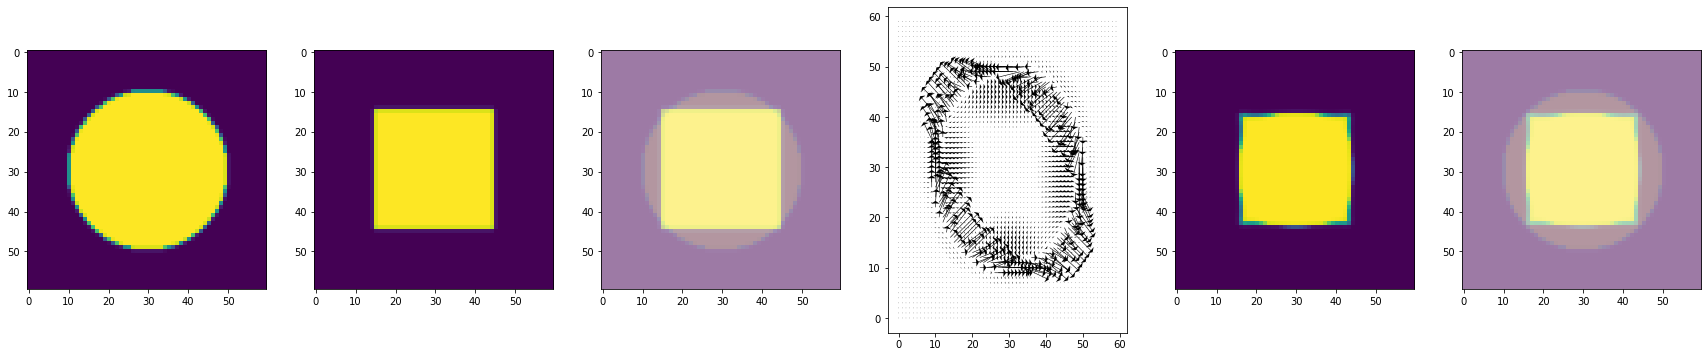

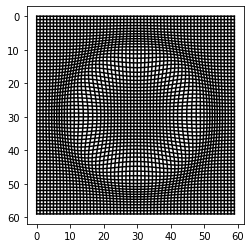

-16.747577576474537 2772.394167228943 0.016802167581555137
17.131821930696837


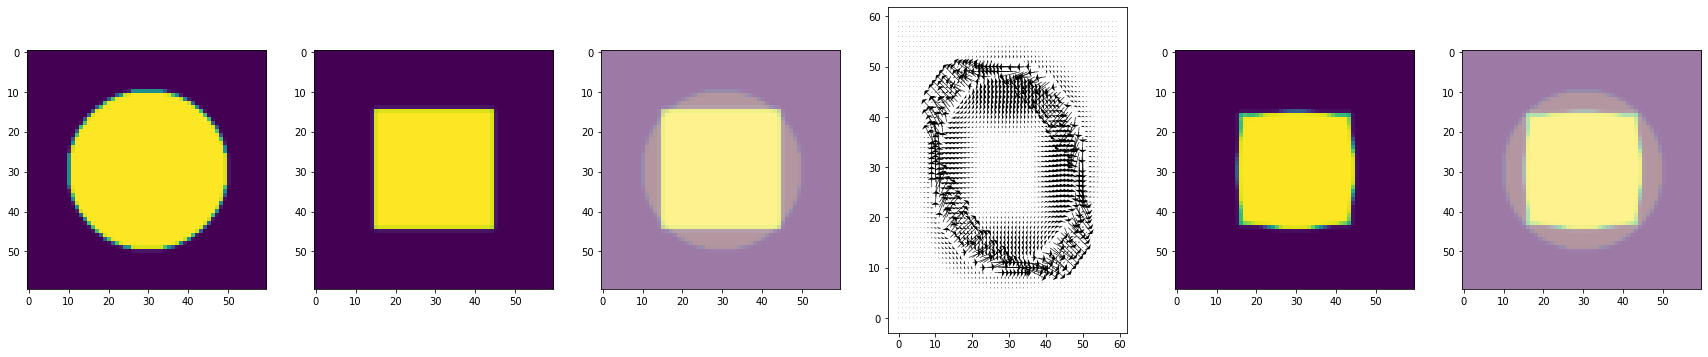

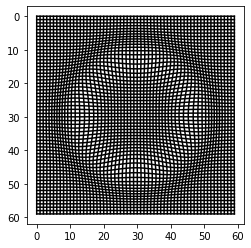

-19.8746079528324 1674.5692512996816 0.036598799910023676
16.604305914213516


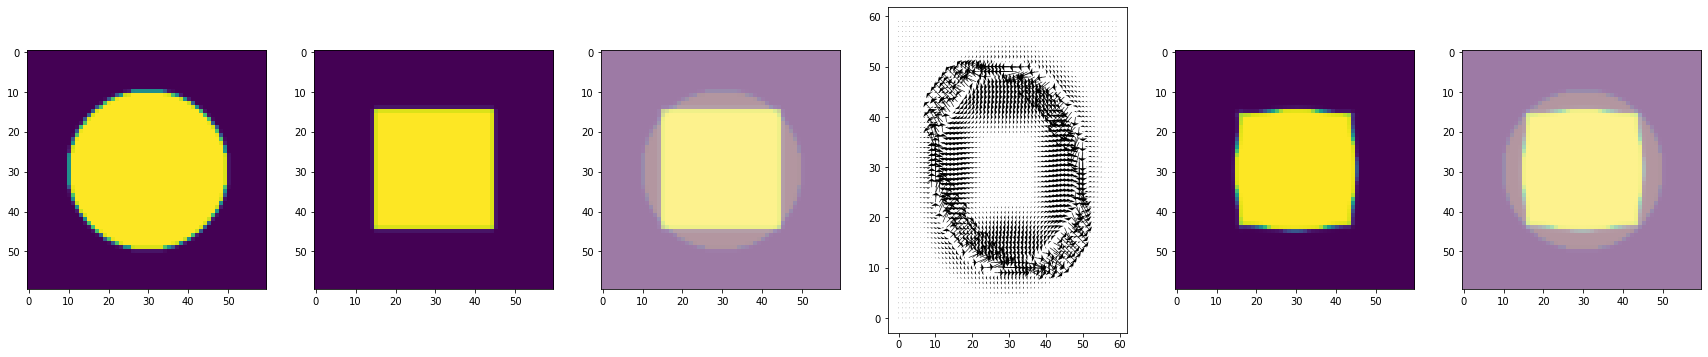

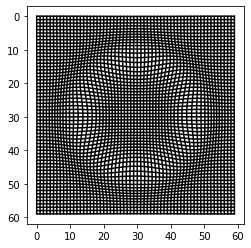

13.942095282412042 1160.6877418471393 0.022726472479145
19.892814140474517


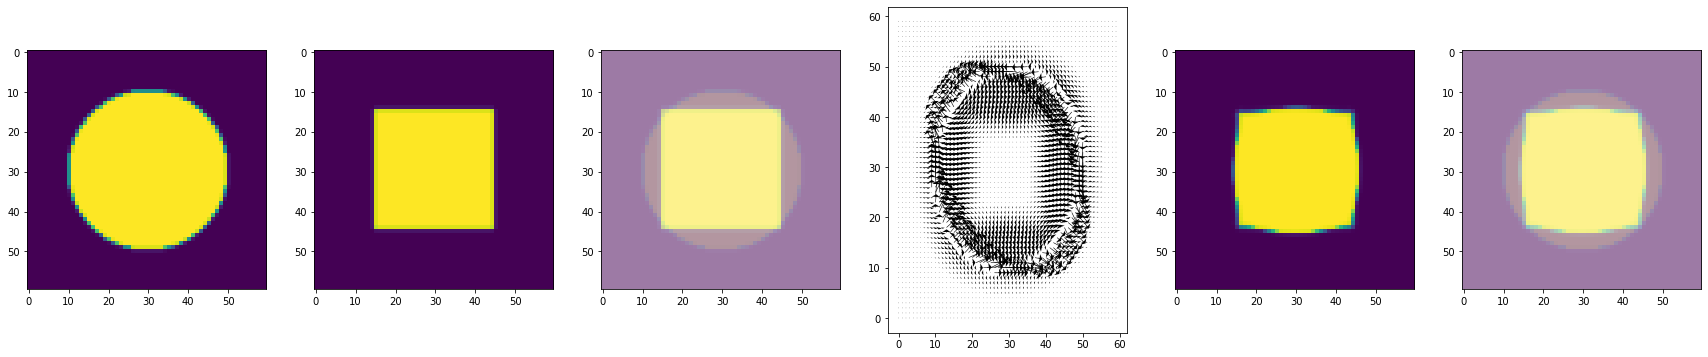

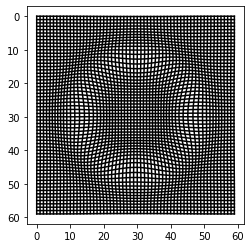

-41.25944449073363 827.447914200933 0.06373890234456725
17.574217460994817


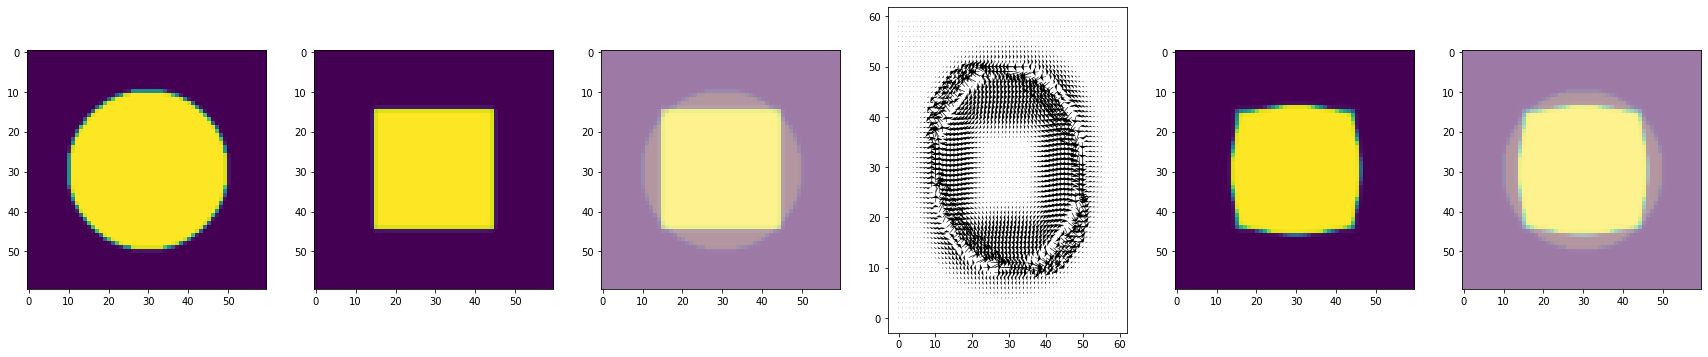

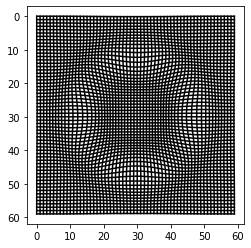

23.9375379251596 689.4151337365076 0.03994812079744579
17.646673234120588


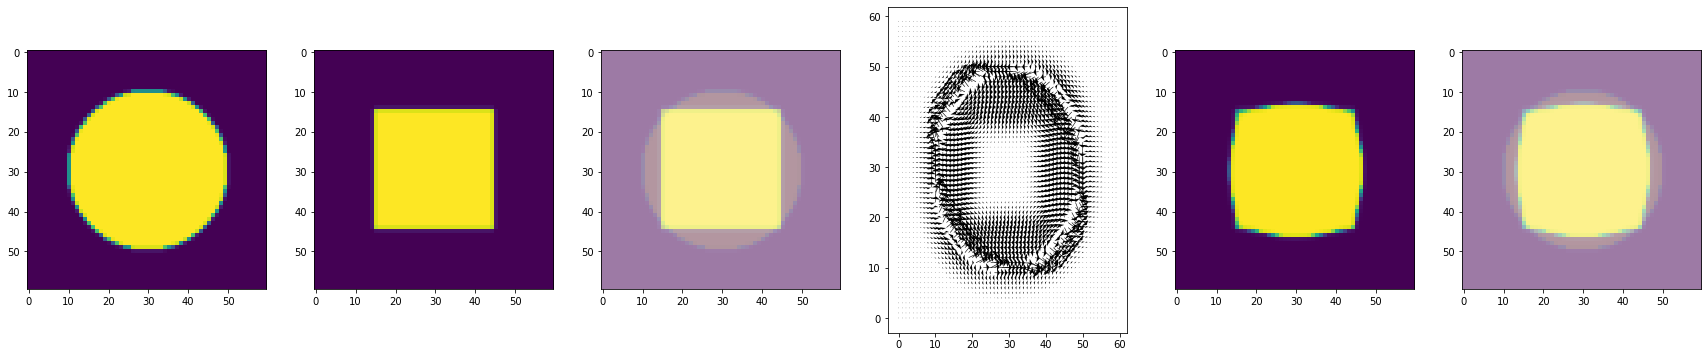

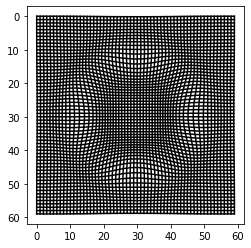

-18.2308761023033 726.3702630057612 0.058037925662317344
16.86388826875426


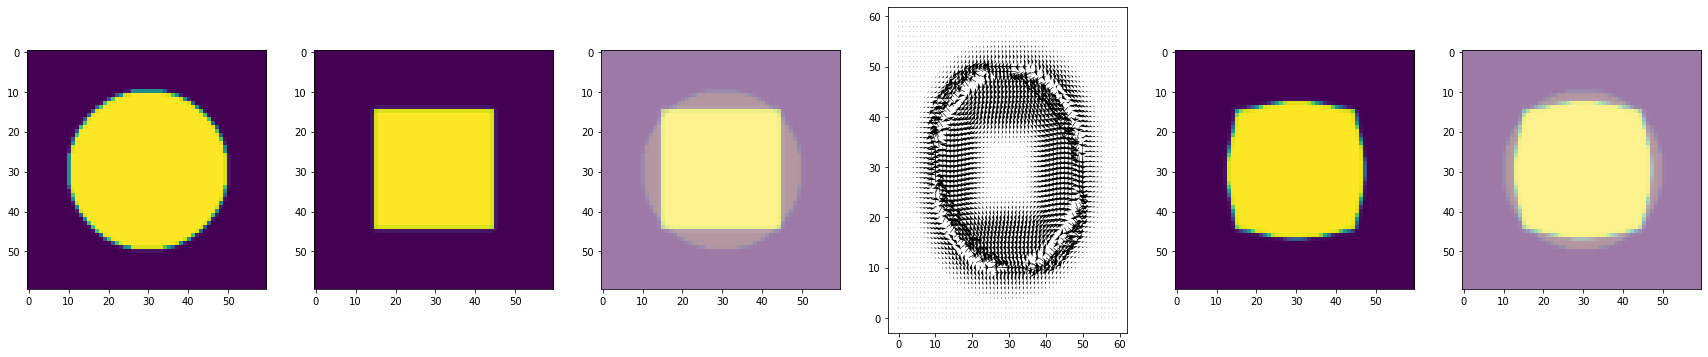

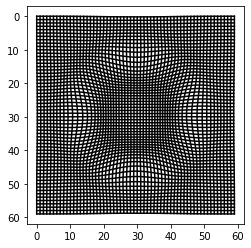

14.003565295290601 1036.8193836753192 0.04414869140869111
16.874401424243022


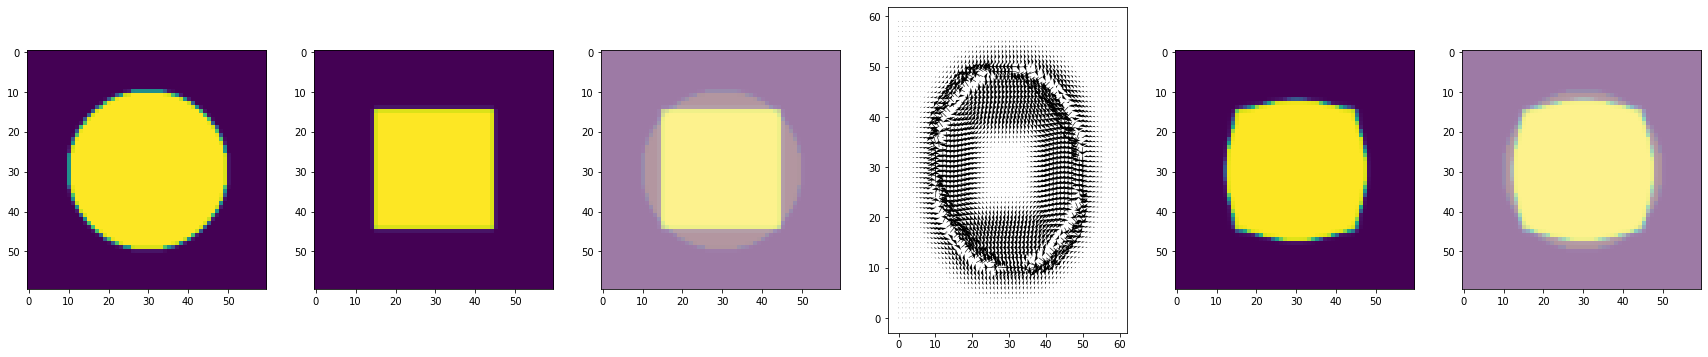

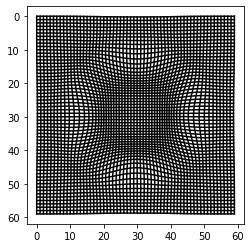

-19.386289788664268 1485.8556778144791 0.0633553207653976
16.103934185384183


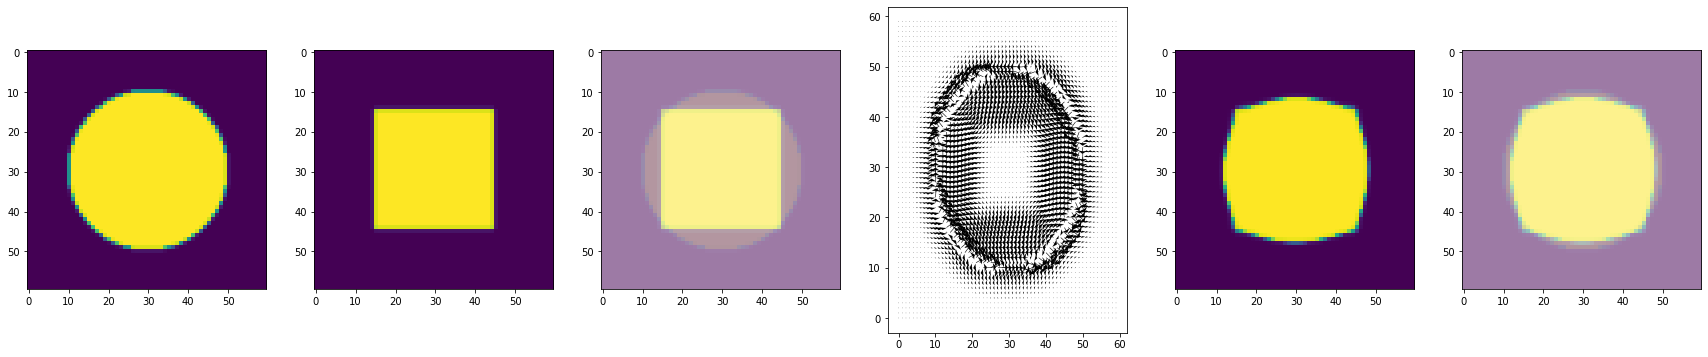

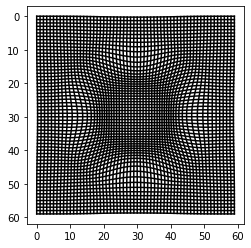

11.752105743059756 2167.011719770711 0.05172262091942786
15.087773829669576


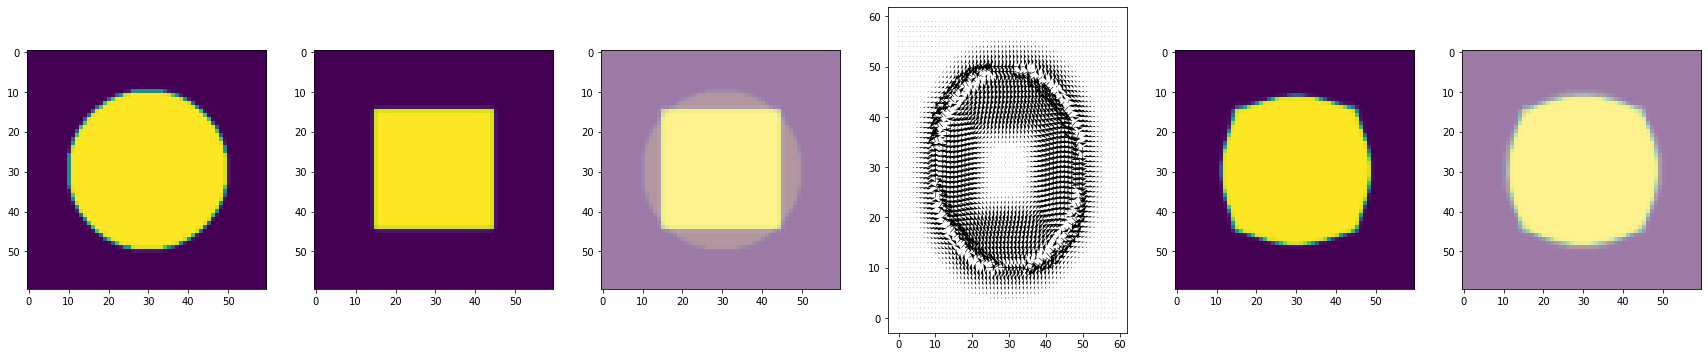

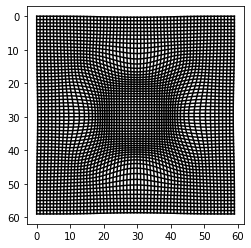

-7.883585754763044 2952.197162058344 0.059467083795271235
14.306202057880212


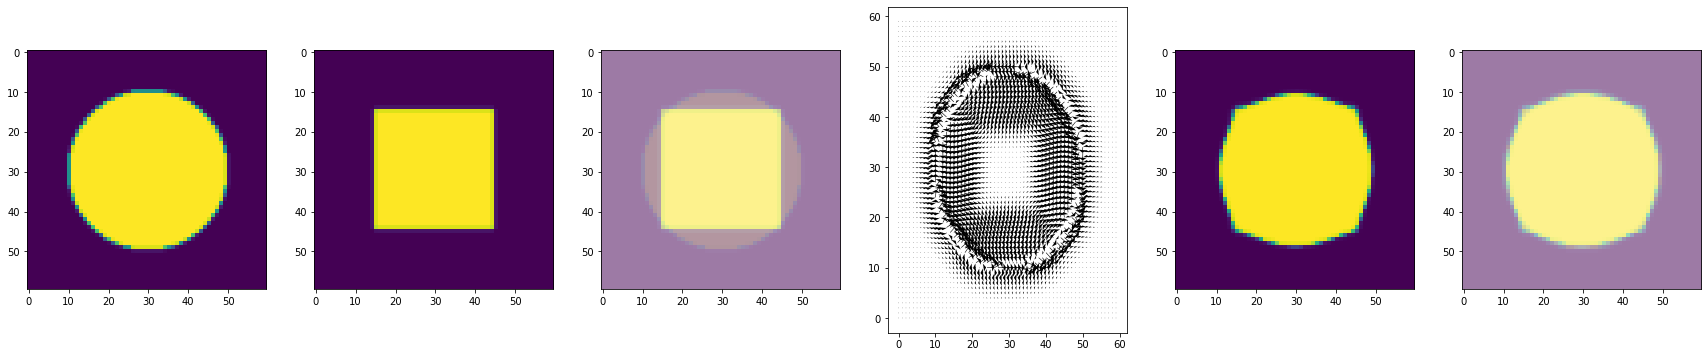

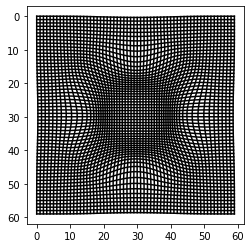

18.173633717797244 3855.497734064692 0.041495189769403217
11.68203499756238


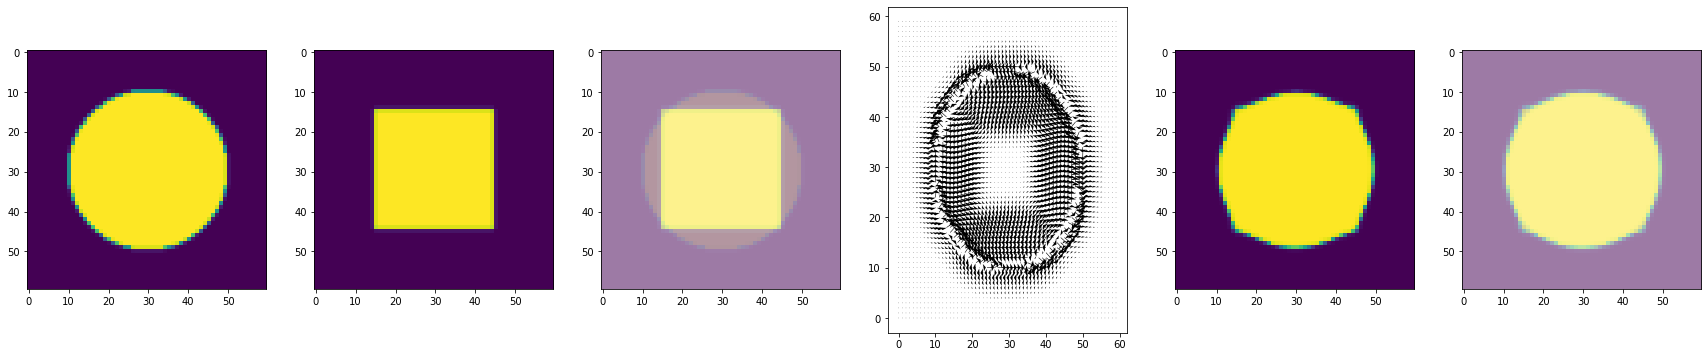

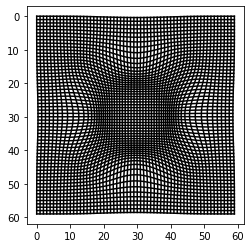

-9.358453169855816 4769.880904957667 0.05068821563661739
9.881734264350715


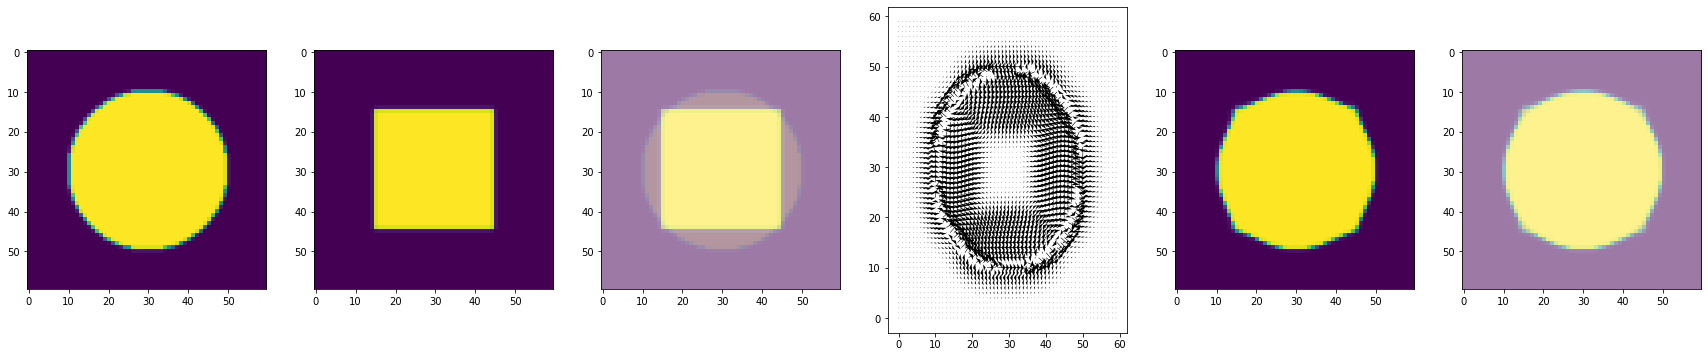

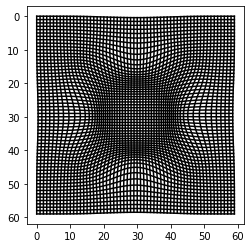

-3.5825653055251605 5599.101079453456 0.05420464404018429
5.103011872930747


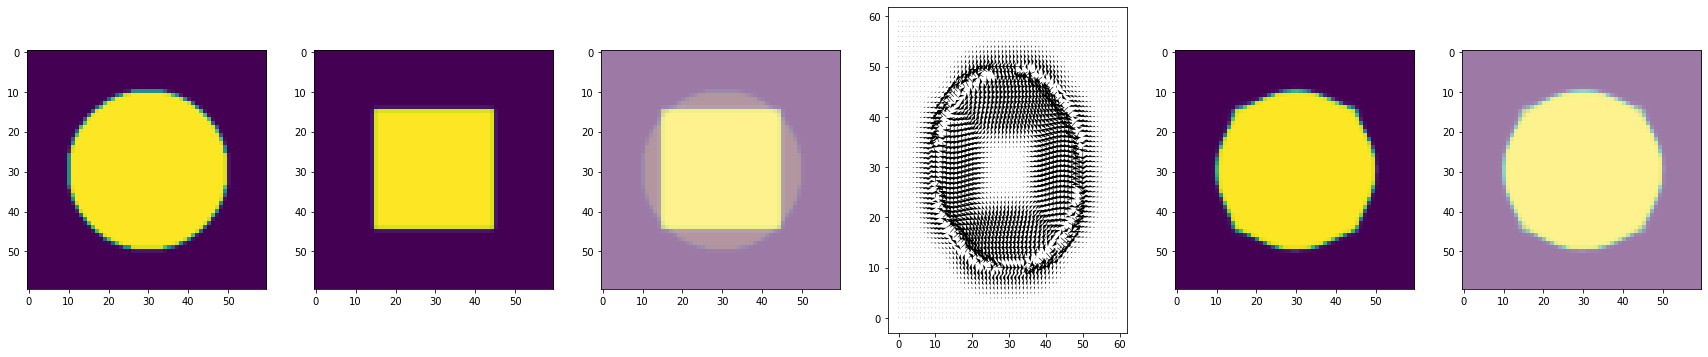

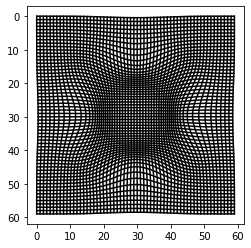

4.035174215481631 6350.468431720248 0.05021668949159759
3.3113127140115313


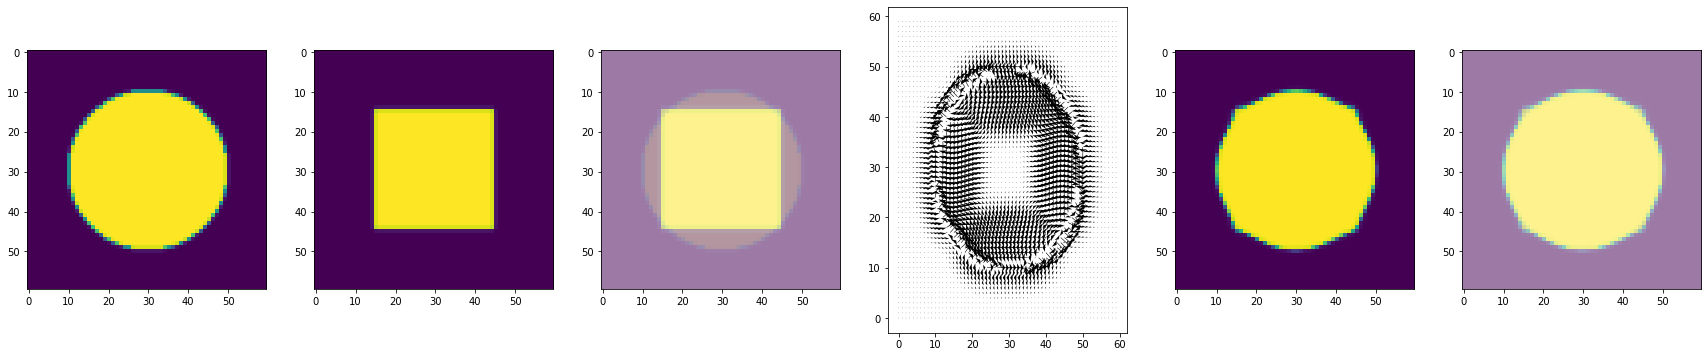

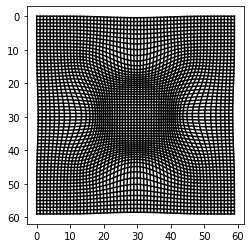

1.6471165676274346 6628.0671862569425 0.04859596427875075
3.026909406003063


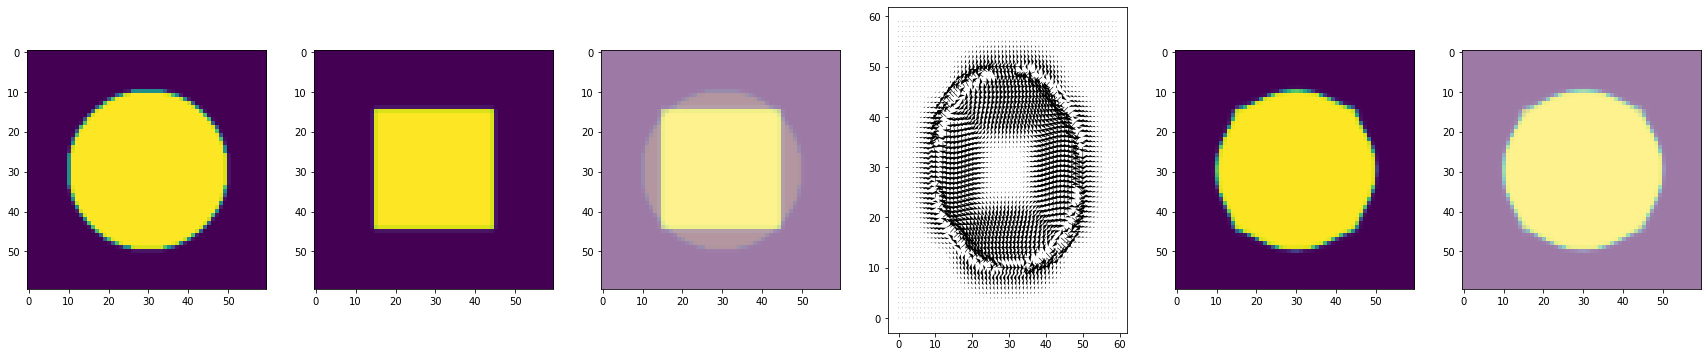

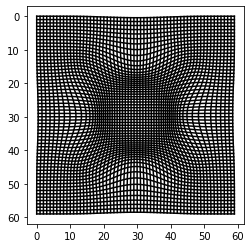

2.149101207471861 6754.442387770201 0.04646652648102025
2.42574818311965


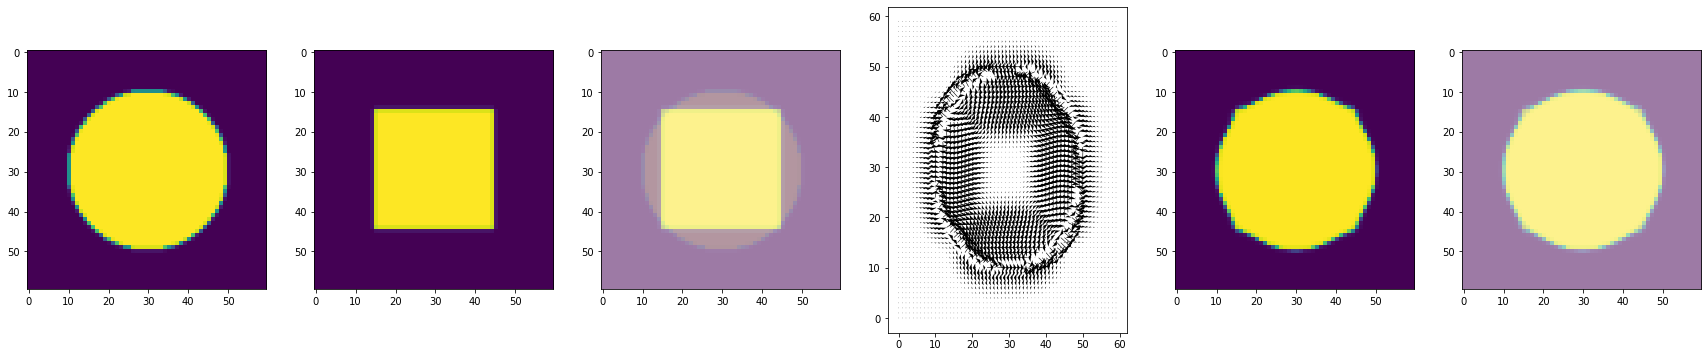

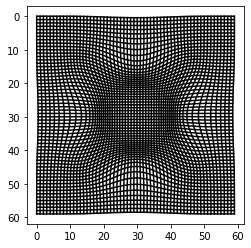

0.0916811785074888 6734.91763837036 0.04638115652196751
2.177847405201461


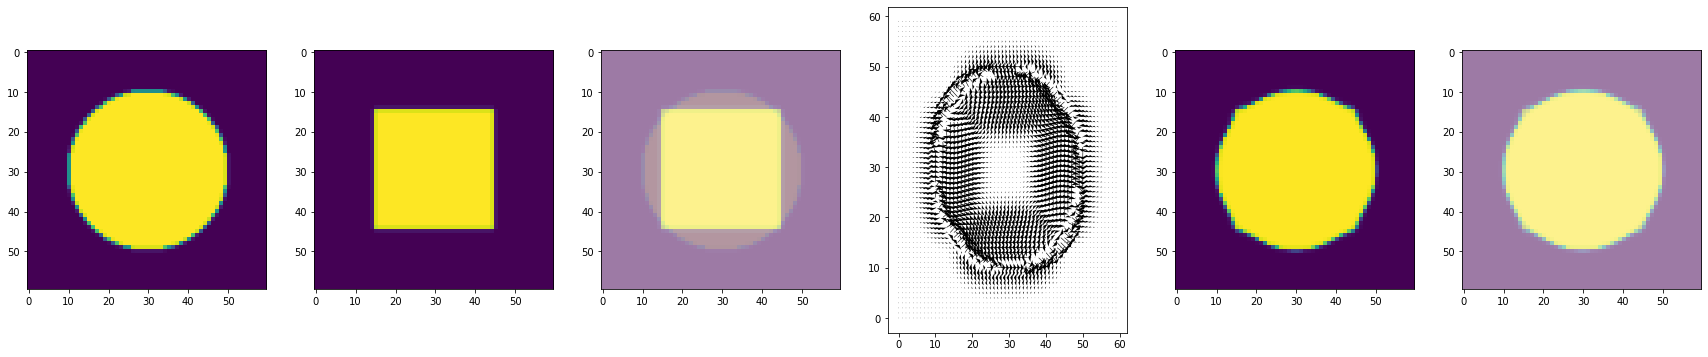

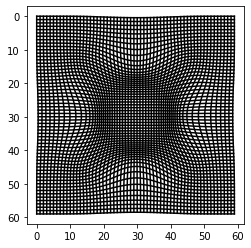

-1.5441074984938636 6756.970715514702 0.0479125140636633
1.9213933484290207


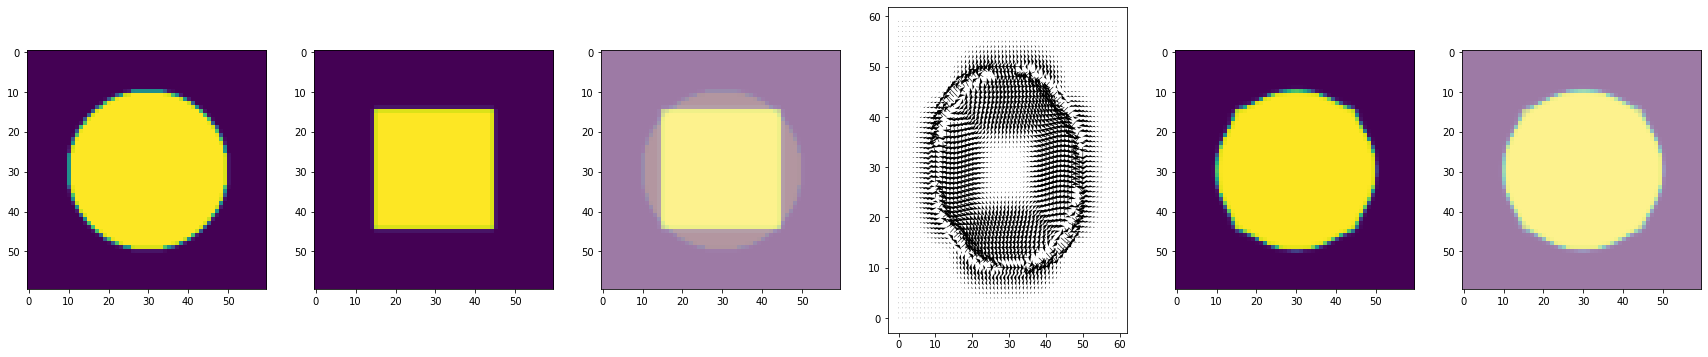

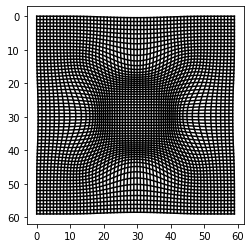

0.3747182063411208 6797.0456210086795 0.047549584359771954
2.2756959048634378


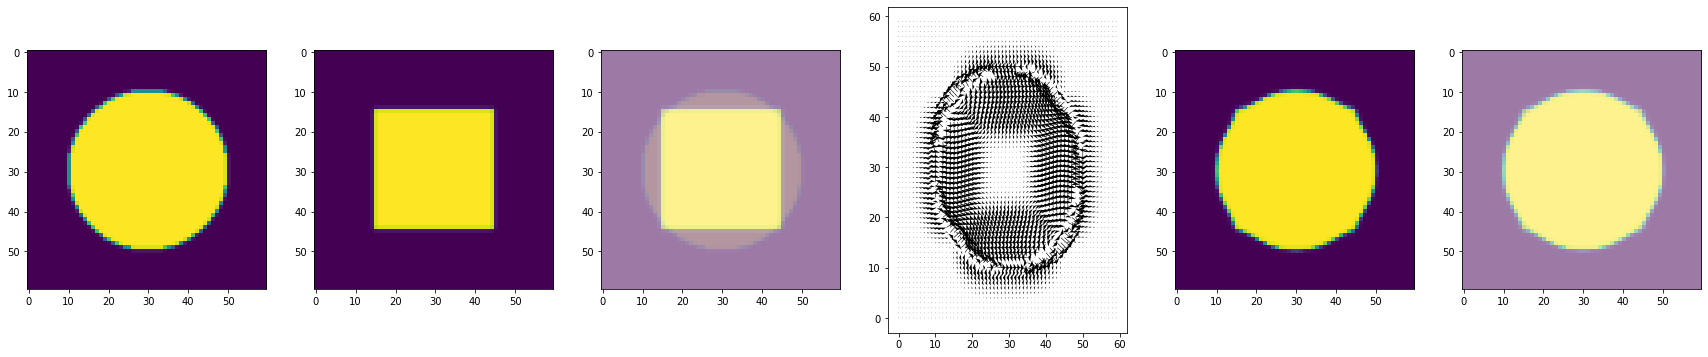

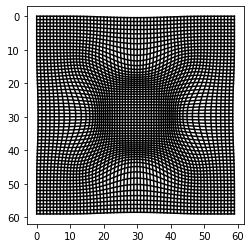

-3.103035094340675 6810.430594223484 0.05064160138978519
1.891968647617655


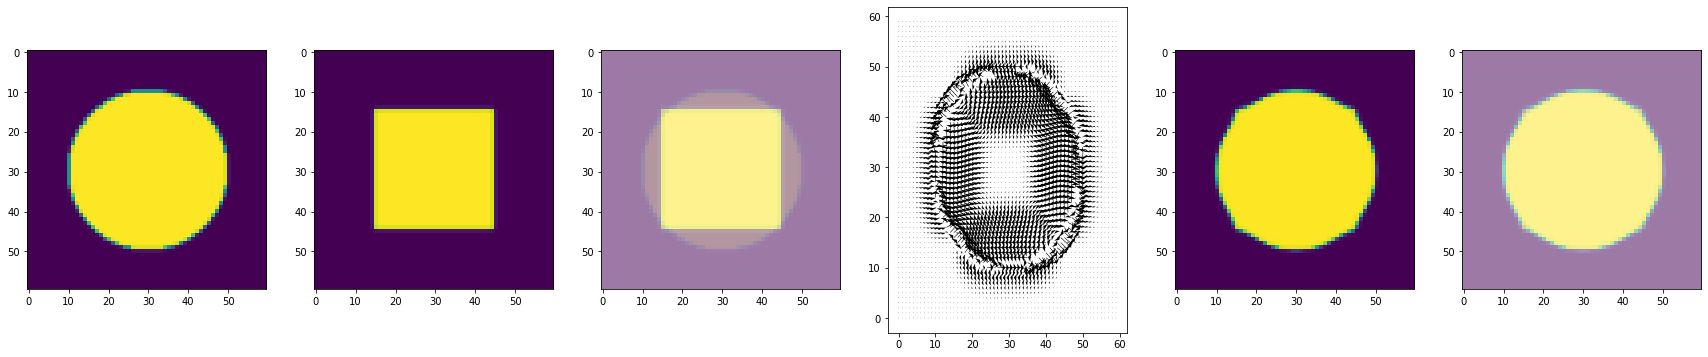

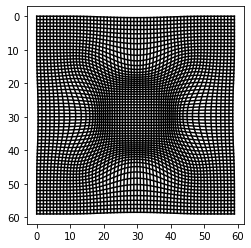

-0.9615194973385637 6807.55430072051 0.051609856830415135
1.6539700437621085


In [ ]:
flow_sigma = 4
## smoothers, and integrators and map advection
w, h = fix.shape
smooth_across_components, smooth_across_time_and_components = get_smoother(smooth,  flow_sigma)
id_map = identity_mapping((w, h))
K = get_normalized_gaussian_kernel(id_map,(w//2, h//2), (flow_sigma, flow_sigma) )
eps = 1e-3
x0 = jnp.arange(0, w)
x1 = jnp.arange(0, h)
t = jnp.linspace(0, 1, 32)
m0 = 1e-1*jnp.asarray(jnp.gradient(fix))
sigma = .05
loss_list = []
grad_list = []
grid_list = []


for i in range(30):
        
    
    loss = cost_functional(m0, K, fix, mov, t, sigma, odeint_rk4,smooth_across_components,smooth_across_time_and_components, advect_map_forward, compute_cc, 
                   regularization)
    
    #print(make_jaxpr(cost_functional)(m0, K, fix, mov, t, sigma))
    
    grad_m0 = grad(cost_functional)(m0, K, fix, mov, t, sigma, odeint_rk4,smooth_across_components,smooth_across_time_and_components, advect_map_forward, similarity.ssd, 
                   regularization)
    m0 = m0 - eps*grad_m0
    
    print (jnp.linalg.norm(eps*grad_m0))
    
    m_int = odeint_rk4(get_dm_dt, m0, t, K, smooth_across_components)
    v_int = smooth_across_time_and_components(m_int, K)
    phi_id = identity_mapping(fix.shape)
    phi_ad_x, phi_ad_y = advect_map_forward(get_dphi_dt, phi_id, t, v_int)
    
    coords = jnp.asarray([phi_ad_y, phi_ad_x])
    warped = jax.scipy.ndimage.map_coordinates(mov, coords, order= 1)
    
    u, v = m0
    
    f, a = plt.subplots(1, 6, figsize =(30, 6))
    a[0].imshow(fix)
    a[1].imshow(mov)
    a[3].quiver(x0, x1, u, v, headwidth = 15)
    a[2].imshow(fix, alpha = .2)
    a[2].imshow(mov, alpha = .4)
    a[4].imshow(warped)
    a[5].imshow(fix, alpha = .2)
    a[5].imshow(warped, alpha = .4)
    
    
    
    show_warp_field(jnp.asarray([phi_ad_x, phi_ad_y]), interval=1, shape = fix.shape, size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)
    
    grid_list.append(jnp.asarray([phi_ad_x, phi_ad_y]))
    plt.show()
    
    
    loss_list.append(loss)
    grad_list.append(jnp.mean(grad_m0))
    
    
    print (jnp.mean(grad_m0), loss, jnp.mean(v_int))
    

In [56]:

def cost_functional(m0, K, fix, mov, t, sigma, odeint_rk4,smooth_across_components,smooth_across_time_and_components, advect_map_forward, data_matching_measure, 
                   regularization):
    """
    the error term which is data matching + regularization 
    """
    
    def shoot(m0, t, K, odeint_rk4, smooth_across_time_and_components, advect_map_forward):
    
        m_int = odeint_rk4(get_dm_dt, m0, t, K, smooth_across_components)
        
        v_int = smooth_across_time_and_components(m_int, K)
        phi_id = identity_mapping(fix.shape)
        phi_ad_x, phi_ad_y = advect_map_forward(get_dphi_dt, phi_id, t, v_int)
        
        coords = jnp.asarray([phi_ad_x, phi_ad_y])
        warped = jax.scipy.ndimage.map_coordinates(mov, coords, order= 1)
        return warped
    
    warped = shoot(m0, t, K,  odeint_rk4, smooth_across_time_and_components, advect_map_forward)
    
    dm = (1/sigma)**2 * data_matching(fix, warped, data_matching_measure)
    
    reg = 0.5 * regularization(m0, K, smooth_across_components)
    
    print (dm, reg)
    
    return  dm + reg


In [55]:
cost_functional(m0, K, fix, mov, t, sigma, odeint_rk4,smooth_across_components,smooth_across_time_and_components, advect_map_forward, lncc, 
                   regularization)

0.00027402252
27.938023 7.9838324


DeviceArray(35.921856, dtype=float32)

In [110]:
phi_id = identity_mapping(fix.shape)
phi_ad_x, phi_ad_y = advect_map_forward(get_dphi_dt, phi_id, t, v_int)

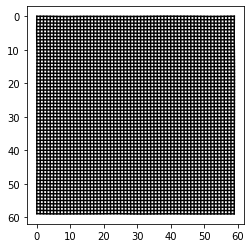

In [111]:
show_warp_field(jnp.asarray([phi_ad_x, phi_ad_y]), interval=1, shape = (60, 60), size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)